In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tifffile

from sklearn.model_selection import train_test_split

import os

import scipy

2023-03-13 07:05:53.858551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 07:05:55.851252: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 07:05:55.851285: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-13 07:06:00.691248: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
tiles = pd.read_csv(r'./Data/Tiles_expanded_road_vector.csv')

In [3]:
tiles.head(5)

,Unnamed: 0,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical,RTTYP
0,0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,M
1,1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,M
2,2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,M
3,3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,M
4,4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,M


Split into training and test

In [4]:
x_train, x_test, y_train, y_test = train_test_split(tiles[['Tile_ID','Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'RTTYP']], 
                                   tiles['Collisions_Future'],
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

Model #1: Linear regression using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates

In [60]:
# x: 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

def create_linear_model():

    input = tf.keras.layers.Input(shape=(6,))
    
    #input_t = tf.data.Dataset.from_tensor_slices(input.to_dict(orient="list"))

   # normalized = layers.Normalization(input_shape=[5,], axis=None)(input)

   #x = normalizer(input_t)

    outputs = layers.Dense(1)(input)

    linear_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="linear_model")

    linear_model.summary()

    linear_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_absolute_error' #,
        #metrics = [tf.keras.metrics.Accuracy()]
        )
    
    return linear_model

linear_model = create_linear_model()

history = linear_model.fit(
    np.asarray(x_train[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]).astype('float32'),
    y_train,
    epochs=20,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Model: "linear_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 1)                 7         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
210/210 [==============================] - 1s 2ms/step - loss: 90.8571 - val_loss: 73.6304
Epoch 2/20
210/210 [==============================] - 0s 2ms/step - loss: 56.6049 - val_loss: 39.4047
Epoch 3/20
210/210 [==============================] - 0s 2ms/step - loss: 22.4328 - val_loss: 5.7622
Epoch 4/20
210/210 [==============================] - 0s 2ms/step - loss: 1.5978 - val_loss: 0.9943
Epoch 5/20
210/210 [==============================]

In [14]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

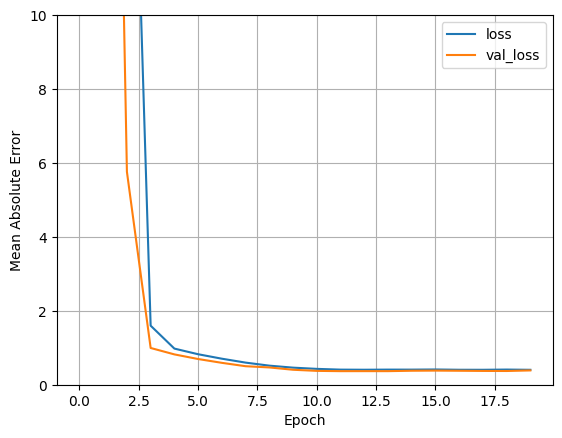

In [62]:
plot_loss(history)

**Model #2: Neural Network Using Satellite Images, Historical Collisions, SFMTA Street Characteristics, and Geocoordinates**

Image Pre-Processing

In [5]:
IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

In [5]:
#eda
img = tifffile.imread('./Satellite Imagery/Satellite Images Tiled/36.tif')[0:148, 0:188, :]
img2 = tifffile.imread('./Satellite Imagery/Satellite Images Tiled/37.tif')[0:148, 0:188, :]

In [6]:
# eda
print(np.shape(img2))

(148, 188, 4)


In [7]:
# eda
test = []
test.append(img[0:148, 0:188, :])
test.append(img2[0:148, 0:188, :])
print(np.shape(test))
test = np.stack(test)
print(np.shape(test))

(2, 148, 188, 4)
(2, 148, 188, 4)


In [6]:
def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [7]:
# THERE IS ONE FILE IN THE "SATELLITE IMAGES TILED" FOLDER THAT IS NOT A TIF IMAGE, DELETE THIS FILE
images_mini = preprocess_data_part1(IMAGE_PATH)

In [69]:
np.shape(images_mini)

(8376, 148, 188, 4)

Road Type Pre-Processing (To One Hot)

In [8]:
from sklearn.preprocessing import LabelBinarizer

In [9]:
road_type = LabelBinarizer().fit_transform(x_train['RTTYP'])

In [10]:
road_type[0]

array([0, 1, 0, 0, 0])

In [11]:
np.shape(road_type)

(8376, 5)

Street Data Pre-Processing

In [10]:
street = np.asarray(x_train[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]).astype('float32')
street_mini = []
for row in range(len(street)):
    concat = np.concatenate((street[row], road_type[row]))
    street_mini.append([[concat]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(8376, 1, 1, 11)

Modeling <br> 

Helpful Links: <br>
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ <br>
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50 <br>
https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py <BR>

In [12]:
# RESNET 18 TAKEN FROM https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py
# HELPS RUN MODEL BELOW

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

def resnet34(x, **kwargs):
    return resnet(x, [3, 4, 6, 3], **kwargs)

In [79]:
# x: Satellite Images, 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,11), name='Input_Street')
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(11, (4,4), activation="relu")(input1)
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=1, activation=None, name='output')(resnet)
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error' #,
    #metrics = [tf.keras.metrics.Accuracy()]
    )

history = cnn_model.fit(
    [images_mini, street_mini],
    np.stack(y_train),
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 145, 185, 11  715         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 71, 91, 11)  0           ['conv2d_9[0][0]']               
                                                                                           

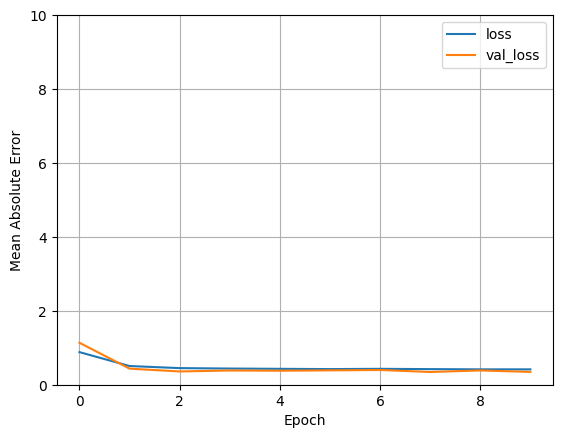

In [80]:
plot_loss(history)

**Model 2.2: Second CNN**

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 145, 185, 11  715         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 71, 91, 11)  0           ['conv2d_10[0][0]']              
 )                                                                                         

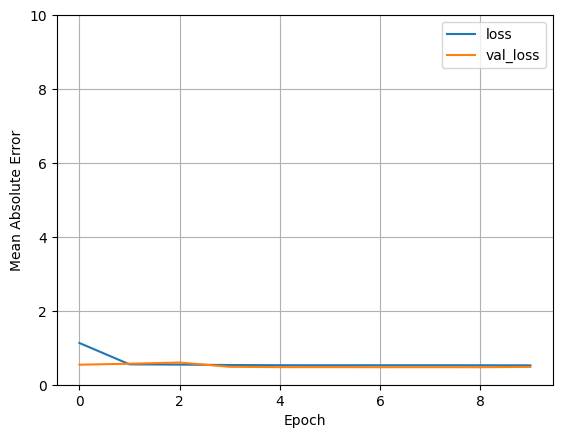

In [81]:
# x: Satellite Images, 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,11), name='Input_Street')
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(11, (4,4), activation="relu")(input1)
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet34(combined)
    output = tf.keras.layers.Dense(units=1, activation=None, name='output')(resnet)
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error' #,
    #metrics = [tf.keras.metrics.Accuracy()]
    )

history = cnn_model.fit(
    [images_mini, street_mini],
    np.stack(y_train),
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

plot_loss(history)

**Model 2.3 CNN with Concatenation instead of Addition between inputs**

In [13]:
street = np.asarray(x_train[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]).astype('float32')
# street_mini = []
# for row in range(len(street)):
#     concat = np.concatenate((street[row], road_type[row]))
#     street_mini.append([[concat]])
# street_mini = np.stack(street_mini)
# np.shape(street_mini)

In [89]:
#np.shape(street_mini[0])

(1, 1, 11)

In [15]:
street_mini_2 = [] 
for k in range(len(street)):
    for i in range(71): 
        for j in range(91):
            concat = np.concatenate((street[k], road_type[k]))
            street_mini_2.append(concat)

In [17]:
street_mini_2 = np.reshape(street_mini_2, (len(street),71,91,11))

In [18]:
np.shape(street_mini_2)

(8376, 71, 91, 11)

In [19]:
# x: Satellite Images, 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(71,91,11), name='Input_Street')
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(11, (4,4), activation="relu")(input1)
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    combined = tf.keras.layers.Concatenate(axis = 3)([images.output, input2])
    #combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=1, activation=None, name='output')(resnet)
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error' #,
    #metrics = [tf.keras.metrics.Accuracy()]
    )

history = cnn_model.fit(
    [images_mini, street_mini_2],
    np.stack(y_train),
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

2023-03-08 20:31:38.348998: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-08 20:31:38.349036: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 20:31:38.349062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-82-179): /proc/driver/nvidia/version does not exist
2023-03-08 20:31:38.351095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initialize

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 145, 185, 11  715         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 71, 91, 11)   0           ['conv2d[0][0]']                 
                                                                                            

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Trainable params: 11,750,812
Non-trainable params: 9,600
__________________________________________________________________________________________________


2023-03-08 20:31:39.348971: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2982732800 exceeds 10% of free system memory.
2023-03-08 20:31:42.087801: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1904702800 exceeds 10% of free system memory.


Epoch 1/10
210/210 [==============================] - 141s 640ms/step - loss: 0.8825 - val_loss: 0.4625
Epoch 2/10
210/210 [==============================] - 131s 623ms/step - loss: 0.5120 - val_loss: 0.4626
Epoch 3/10
210/210 [==============================] - 129s 616ms/step - loss: 0.4422 - val_loss: 0.4115
Epoch 4/10
210/210 [==============================] - 130s 619ms/step - loss: 0.4417 - val_loss: 0.4626
Epoch 5/10
210/210 [==============================] - 129s 616ms/step - loss: 0.4325 - val_loss: 0.3588
Epoch 6/10
210/210 [==============================] - 129s 615ms/step - loss: 0.4143 - val_loss: 0.3751
Epoch 7/10
210/210 [==============================] - 127s 605ms/step - loss: 0.4152 - val_loss: 0.3528
Epoch 8/10
210/210 [==============================] - 125s 596ms/step - loss: 0.4017 - val_loss: 0.3658
Epoch 9/10
210/210 [==============================] - 127s 603ms/step - loss: 0.4044 - val_loss: 0.3527
Epoch 10/10
210/210 [==============================] - 125s 597m

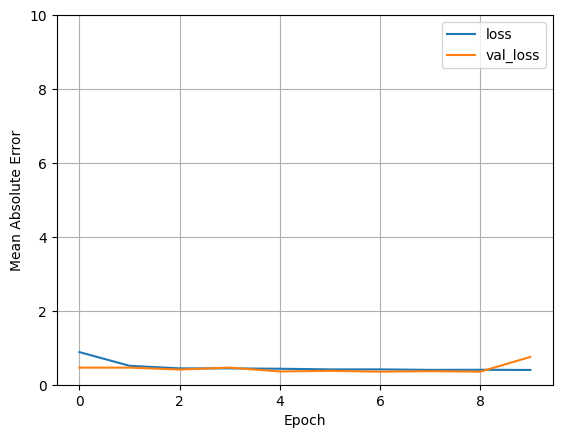

In [22]:
plot_loss(history)

**Model 2.4 CNN WITH ADDITION AND RESNET 50 FROM TENSORFLOW**

In [24]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /home/ubuntu/.cache/torch/hub/v0.10.0.zip


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# x: Satellite Images, 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,11), name='Input_Street')
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(11, (4,4), activation="relu")(input1)
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    # RESNET50 FROM TENSORFLOW 
    resnet = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights=None,
    input_tensor=combined,
    input_shape=(71, 91, 11,),
    pooling=None,
    classes=0,
    #**kwargs
    )
    
    output = tf.keras.layers.Dense(units=1, activation=None, name='output')(resnet.output)
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model #cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error' #,
    #metrics = [tf.keras.metrics.Accuracy()]
    )

history = cnn_model.fit(
    [images_mini, street_mini],
    np.stack(y_train),
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

plot_loss(history)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 145, 185, 11  715         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 71, 91, 11)  0           ['conv2d_2[0][0]']               
                                                                                            

2023-03-13 07:28:27.577830: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2982732800 exceeds 10% of free system memory.


210/210 [==============================] - 230s 1s/step - loss: 0.8414 - val_loss: 0.6409
Epoch 2/10
210/210 [==============================] - 207s 986ms/step - loss: 0.5895 - val_loss: 0.8612
Epoch 3/10
210/210 [==============================] - 206s 983ms/step - loss: 0.5707 - val_loss: 0.5236
Epoch 4/10
210/210 [==============================] - 208s 988ms/step - loss: 0.5538 - val_loss: 0.4769
Epoch 5/10
210/210 [==============================] - 208s 990ms/step - loss: 0.5477 - val_loss: 0.5056
Epoch 6/10
210/210 [==============================] - 206s 980ms/step - loss: 0.5453 - val_loss: 0.4771
Epoch 7/10
210/210 [==============================] - 207s 987ms/step - loss: 0.5420 - val_loss: 0.4815
Epoch 8/10
210/210 [==============================] - 207s 988ms/step - loss: 0.5411 - val_loss: 0.4896
Epoch 9/10
210/210 [==============================] - 206s 982ms/step - loss: 0.5415 - val_loss: 8.1431
Epoch 10/10
210/210 [==============================] - 208s 989ms/step - loss:

NameError: name 'plot_loss' is not defined

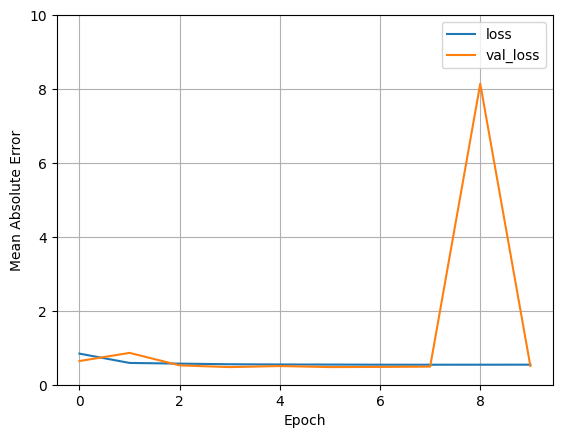

In [15]:
plot_loss(history)